In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import moviepy
from skimage.feature import hog
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import os
import pandas as pd
import random
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
import pickle

%matplotlib inline

In [2]:
## FUNCTIONS FROM LECTURE ##


def hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
        return features

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [100]:
im = plt.imread('./data/vehicles_smallset/cars2/403.jpeg')
im_n = plt.imread('./data/non-vehicles_smallset/notcars1/extra011.jpeg')

im_gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) 
im_n_gray = cv2.cvtColor(im_n, cv2.COLOR_RGB2GRAY)

In [103]:
_,hog_im = hog_features(im_gray,9,8,2,True)
_,hog_im_n = hog_features(im_n_gray,9,8,2,True)

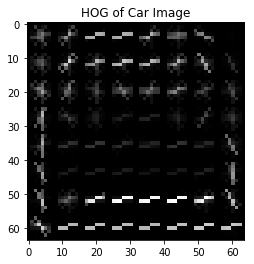

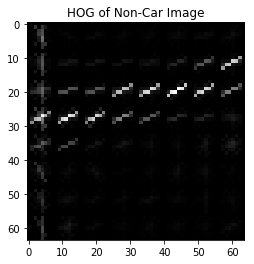

In [104]:
plt.imshow(hog_im,'gray')
plt.title('HOG of Car Image')
plt.show()
plt.imshow(hog_im_n,'gray')
plt.title('HOG of Non-Car Image')
plt.show()

### Step 1: Train a classifier 
(using HOG features with appended color hist features)

In [3]:
# sharpens the edges of image
def sharpen_img(img):
    kernel = np.array([[-1,-1,-1,-1,-1],
                         [-1,2,2,2,-1],
                         [-1,2,16,2,-1],
                         [-1,2,2,2,-1],
                         [-1,-1,-1,-1,-1]]) / 16.
    sharp_img = cv2.filter2D(img, -1, kernel)
    return sharp_img

In [4]:
# get the image locations
def get_image_locs():
    # save car image locations
    cars_main_folder = './data/vehicles_smallset/'
    cars = [] # store file paths of car images here
    cars_subdirs = [sub for sub,_,_ in os.walk(cars_main_folder)][1:]# first entry is that folder itself
    # iterate through the contents of subfolders to get image paths
    for cars_subdir in cars_subdirs:
        for file in os.listdir(cars_subdir):
            if '.jpeg' not in file: continue # all images here are jpeg files
            file_path = cars_subdir + '/' + file
            cars.append(file_path)
    # save non-car image locations
    non_cars_main_folder = './data/non-vehicles_smallset/'
    non_cars = [] # store file paths of car images here
    non_cars_subdirs = [sub for sub,_,_ in os.walk(non_cars_main_folder)][1:]
    # iterate through the contents of subfolders to get image paths
    for non_cars_subdir in non_cars_subdirs:
        for file in os.listdir(non_cars_subdir):
            if '.jpeg' not in file: continue # all images here are jpeg 
            file_path = non_cars_subdir + '/' + file
            non_cars.append(file_path)
    
    return cars, non_cars

In [5]:
# get images in gray scale or color (RGB)
def get_images(img_path_lst, color_channel='gray', flat=False, return_image_info=False): 
    img_lst = []
    for img_path in img_path_lst:
        img = plt.imread(img_path)
        if return_image_info: # currently just the shape
            img_shape = img.shape
        if color_channel == 'gray':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        if color_channel == 'HLS':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        if color_channel == 'YCrCb':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        if color_channel == 'LUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        if flat:
            img = img.flatten()
        img_lst.append(img)
    if return_image_info: return img_lst, img_shape
    return img_lst

In [6]:
# returns a list of arrays of HOG features
# no grayscale
def get_hog_feats(img_lst, sharpen=True, orient=9, pix_per_cell=8, cell_per_block=3):
    
    img_hog_lst = []
    for img in img_lst:
        if sharpen: img = sharpen_img(img)
        ch1,ch2,ch3 = img[:,:,0], img[:,:,1], img[:,:,2]
        all_ch_hog = []
        for ch in [ch1,ch2,ch3]:
            ch_hog = hog_features(ch, orient, pix_per_cell, cell_per_block,
                            vis=False, feature_vec=True)
            all_ch_hog.append(ch_hog)
        img_hog = np.concatenate(all_ch_hog)
        img_hog_lst.append(img_hog)
        
    return img_hog_lst

In [7]:
# returns a list of arrays of the color histograms
def add_color_hist(img_lst, bins=32):
    
    img_color_hist_lst = []
    for img in img_lst:
        img_color_hist = color_hist(img, nbins=bins)
        img_color_hist_lst.append(img_color_hist)
    
    return img_color_hist_lst    

In [8]:
# combines two feature arrays, min max scales, and (optionally) returns the scaler object for use later
def combine_scale_split(X_1, X_2, y, scale=True, return_scaler=False):
    
    X_1 = np.array(X_1)
    X_2 = np.array(X_2)
    
    X = np.hstack((X_1,X_2)) # cbind
    
    if scale:
        scaler = RobustScaler().fit(X)
        X_scaled = scaler.transform(X)
    else:
        X_scaled = X
        
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=99)
    
    if return_scaler:
        return X_train, X_test, y_train, y_test, scaler
    return X_train, X_test, y_train, y_test

In [9]:
# machine learning pipeline (uses SVM classifier)

def classification_pipeline(car_path_lst, non_car_path_lst, color_map, bins, HOG_sharpen, 
                            HOG_orient, HOG_pix_per_cell, HOG_cell_per_block, svm_kernel):
    
    #global X_1, X_2 # added for debugging
    car_lst = get_images(car_path_lst, color_channel=color_map); car_len = len(car_lst)
    non_car_lst = get_images(non_car_path_lst, color_channel=color_map); non_car_len = len(non_car_lst)
    complete_lst = car_lst + non_car_lst
    y = ['car']*car_len + ['not_car']*non_car_len # this is the target array
    # get the hog features
    X_1 = get_hog_feats(complete_lst, sharpen=HOG_sharpen, orient=HOG_orient, 
                       pix_per_cell=HOG_pix_per_cell, cell_per_block=HOG_cell_per_block)
    
    # get color histograms
    X_2 = add_color_hist(complete_lst, bins=bins)
    
    # combine, scale, and get the test and train sets
    X_train, X_test, y_train, y_test, scaler = combine_scale_split(X_1, X_2, y, scale=True, return_scaler=True)
    
    # apply SVC to get performance
    fit = SVC(kernel=svm_kernel).fit(X_train, y_train)
    score = fit.score(X_test, y_test)
    
    return score, fit, scaler 


In [10]:
# get the performance for different parameters
def grid_search(car_paths, non_car_paths, 
                params ={
                  'color_map_lst':['HLS','YCrCb','LUV'],
                  'bins':[32,64],
                  'sharpen':[True],
                  'orient':[9,11],
                  'pix_per_cell':[8],
                  'cell_per_block':[2],
                  'svm_kernel':['rbf','linear']
                 }):
    
    df = pd.DataFrame(columns=['Color_map','Bins','HOG_sharpen','HOG_orientation',
                               'HOG_pixels_cell','HOG_cells_block', 'SVM_kernel','SCORE'])
    best_score = 0
    i = 0 
    for color in params['color_map_lst']:
        for bin_ in params['bins']:
            for sharp in params['sharpen']:
                for orientation in params['orient']:
                    for pix in params['pix_per_cell']:
                        for cell in params['cell_per_block']:
                            for kernel in params['svm_kernel']:
                                
                                score, fit,_ = classification_pipeline(car_paths, non_car_paths,
                                                                            color,bin_,sharp,orientation,pix,
                                                                             cell,kernel)
                                params_lst = [color, bin_, sharp, orientation, pix, cell, kernel, score]
                                i += 1 # increment to next index
                                df.loc[i] = params_lst # add row to dataframe
                                print('Combination: '+str(i)+' done. Score: ' + str(score))
                                if score >= best_score: # check if score has improved
                                    best_fit = fit
                                    #best_scaler = scaler 
                                    best_params = params_lst
                                    best_score = score
    
    #return best_fit, best_scaler, best_score, best_params, df
    return best_fit, best_score, best_params, df
    

#### Perform a Grid Search to find best param combination
We have 24 combinations

In [52]:
cars, non_cars = get_image_locs()

In [53]:
%%time
fit_, score_, params_, df = grid_search(cars, non_cars)

Combination: 1done. Score: 0.992826398852
Combination: 2done. Score: 0.995695839311
Combination: 3done. Score: 0.991391678623
Combination: 4done. Score: 0.995695839311
Combination: 5done. Score: 0.994261119082
Combination: 6done. Score: 0.997130559541
Combination: 7done. Score: 0.994261119082
Combination: 8done. Score: 0.997130559541
Combination: 9done. Score: 0.987087517934
Combination: 10done. Score: 0.99856527977
Combination: 11done. Score: 0.978479196557
Combination: 12done. Score: 0.99856527977
Combination: 13done. Score: 0.977044476327
Combination: 14done. Score: 0.994261119082
Combination: 15done. Score: 0.972740315638
Combination: 16done. Score: 0.995695839311
Combination: 17done. Score: 0.979913916786
Combination: 18done. Score: 0.997130559541
Combination: 19done. Score: 0.975609756098
Combination: 20done. Score: 0.997130559541
Combination: 21done. Score: 0.954088952654
Combination: 22done. Score: 0.995695839311
Combination: 23done. Score: 0.945480631277
Combination: 24done. S

In [54]:
df

,Color_map,Bins,HOG_sharpen,HOG_orientation,HOG_pixels_cell,HOG_cells_block,SVM_kernel,SCORE
1,HLS,32,True,9,8,2,rbf,0.992826
2,HLS,32,True,9,8,2,linear,0.995696
3,HLS,32,True,11,8,2,rbf,0.991392
4,HLS,32,True,11,8,2,linear,0.995696
5,HLS,64,True,9,8,2,rbf,0.994261
6,HLS,64,True,9,8,2,linear,0.997131
7,HLS,64,True,11,8,2,rbf,0.994261
8,HLS,64,True,11,8,2,linear,0.997131
9,YCrCb,32,True,9,8,2,rbf,0.987088
10,YCrCb,32,True,9,8,2,linear,0.998565


In [55]:
params_

['YCrCb', 32, True, 11, 8, 2, 'linear', 0.99856527977044474]

Hence, based on this search we are getting a very high test set accuracy of 0.989 using YCrCb color map with a combination of color histogram with 64 bins and HOG features with 9 different orientations, 8 pixels per cell, and 2 cells per block. We also sharpened the image and a linear kernel for SVM.

The *fit_* object can be used be used to classify an unknown image and the *scaler_* object is used to scale data using the same values that were applied to the data used in the chosen model. This will ensure accuracte results.

Since HOG is **not** scale invariant| we need to first resize test image before classifying it. 

#### Retrain the classifier using the chosen parameters on full data

In [57]:
# save car image locations
cars_main_folder = './full_data/vehicles/'
cars = [] # store file paths of car images here
cars_subdirs = [sub for sub,_,_ in os.walk(cars_main_folder)][1:]# first entry is that folder itself
# iterate through the contents of subfolders to get image paths
for cars_subdir in cars_subdirs:
    for file in os.listdir(cars_subdir):
        if '.jpeg' in file or '.png' in file or '.jpg' in file: 
            file_path = cars_subdir + '/' + file
            cars.append(file_path)
# save non-car image locations
non_cars_main_folder = './full_data/non-vehicles/'
non_cars = [] # store file paths of car images here
non_cars_subdirs = [sub for sub,_,_ in os.walk(non_cars_main_folder)][1:]
# iterate through the contents of subfolders to get image paths
for non_cars_subdir in non_cars_subdirs:
    for file in os.listdir(non_cars_subdir):
        if '.jpeg' in file or '.png' in file or '.jpg' in file:  
            file_path = non_cars_subdir + '/' + file
            non_cars.append(file_path)
    

In [58]:
# Retrain classifier using above parameters
car_lst = get_images(cars, color_channel='YCrCb'); car_len = len(car_lst)
non_car_lst = get_images(non_cars, color_channel='YCrCb'); non_car_len = len(non_car_lst)
complete_lst = car_lst + non_car_lst
y = ['car']*car_len + ['not_car']*non_car_len # this is the target array

# get hog features
X_1 = get_hog_feats(complete_lst, sharpen=True, orient=11, 
                   pix_per_cell=8, cell_per_block=2)

# get color histograms
complete_lst = car_lst + non_car_lst
X_2 = add_color_hist(complete_lst, bins=32)

# combine, scale, and get the test and train sets
X_train, X_test, y_train, y_test, scaler = combine_scale_split(X_1, X_2, y, scale=True, return_scaler=True)

# apply SVC to get performance
fit = SVC(kernel='linear',probability=True).fit(X_train, y_train)
score = fit.score(X_test, y_test)

In [67]:
# final classifier score:
print(score)
# save model and scaler for future use without retraining
import pickle
model = {'fit':fit,'scaler':scaler}
with open('./model.p','wb') as f:
    pickle.dump(model,f)

0.985735735736


In [11]:
############# IF RESTARTING, GET MODEL AND SCALER FROM HERE ##################
loader = pickle.load(open('./model.p','rb'))
fit, scaler = loader['fit'], loader['scaler']

In [12]:
def classify_img(img, fit=fit, scaler=scaler): # input img must be rgb
    
    # resize image to the same size as images in training data
    img = cv2.resize(img,(64,64))
    # sharpen image
    img = sharpen_img(img)
    # get images with right color maps
    color = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    # get features
    #global hog_feats, color_hist_feats
    # hog
    ch_hog_lst = []
    for ch in [color[:,:,0], color[:,:,1], color[:,:,2]]:
        ch_hog = hog_features(ch,orient=11, pix_per_cell=8, cell_per_block=2)
        ch_hog_lst.append(ch_hog)
    hog_feats = np.concatenate(ch_hog_lst)
    # color hist
    color_hist_feats = color_hist(color, nbins=32)
    all_feats = np.hstack([hog_feats, color_hist_feats])
    # scaling image
    scaled = scaler.transform([all_feats])
    # predict
    prediction = fit.predict(scaled)
    proba = fit.predict_proba(scaled)
    
    return prediction[0], proba[0][0] # the first probability result corresponds to car

In [13]:
img = plt.imread('./data/non-vehicles_smallset/notcars2/image0204.jpeg')
classify_img(img)

('not_car', 3.0000008999999801e-14)

In [14]:
#### SANITY CHECK #####
folder = './data/non-vehicles_smallset/notcars1/'
for img_path in os.listdir(folder):
    img = plt.imread(folder + img_path)
    #print(classify_img(img))

### Step 2: Implement Sliding Window of different window sizes

In [74]:
# Step 2: Implement Sliding Window of different window sizes

# takes in an image and returns coordinates of windows with positive car detections
# the quickest approach is to avoid overlapping windows of the same size
# vis=True draws all rectangles (not just positive ones)
# each vertical area will be covered by a different window 
def find_good_windows(img, start_hw=[400,400], h_bounds=[475,550,620], w_bounds=[720,750,850],
                      window_sizes=[65,85,120], factor=[0.2,0.3,0.15], w_max=[1000,1200,1300], viz=False):
    
    if viz: img_copy = np.copy(img)
    positive_windows = [] # list to hold all windows that contain a car
    start_h, start_w = start_hw
    #sizes_count = max_size//min_size # number of different window sizes
    #curr_size = min_size
    
    for curr_size, end_h, start_w_wind, factor, end_w  in zip(window_sizes, 
                                                       h_bounds, w_bounds, factor, w_max):
        delta_h, delta_w = curr_size, curr_size
        start_w = start_w_wind
        # pick a different color for each window
        if viz: color = (random.randint(190,255), random.randint(190,255), random.randint(190,255))
        while True:
            # if we reach right corner then break
            if start_w + delta_w > end_w and start_h + delta_h >= end_h: 
                start_h, start_w = start_hw # go to starting point of width
                break
            # if we traversed the entire width but not the height
            if start_w + delta_w > end_w and start_h + delta_h < end_h:
                start_h += int(delta_h*factor)
                start_w = start_w_wind # go to starting point of width
            # if not crossing image border
            image_window = img[start_h:start_h+delta_h, start_w:start_w+delta_w,:]
            if viz: cv2.rectangle(img_copy, (start_w, start_h), (start_w+delta_w, start_h+delta_h), color, 6)
            pred, prob = classify_img(image_window)
            if prob > 0.55: # higher probability used to weed out some of the false positives
                # if positive (car detected, append the diagnol coords of bounding box)
                # since for some odd reason cv2 uses y,x not x,y (w,h not h,w)
                positive_windows.append([(start_w, start_h),(start_w+delta_w, start_h+delta_h)])
                #print(delta_h, delta_w)
                # color a positive window in red
                if viz: cv2.rectangle(img_copy, (start_w, start_h), (start_w+delta_w, start_h+delta_h), (255,0,0), 6)
                
            start_w += int(delta_w*factor)
            #start_h = end_h
    
    if viz:
        plt.imshow(img_copy)
        plt.title('Image with all windows')
        plt.show()
    
    # return only the windows that have a positive car detection
    return positive_windows
    

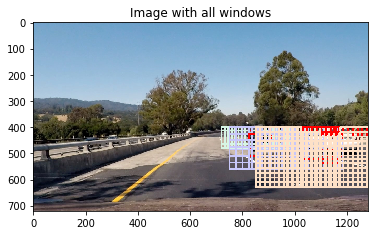

In [75]:
img = plt.imread('./test_images/test4.jpg')
#img = sharpen_img(img)
good_windows = find_good_windows(img, viz=True)

In [76]:
def draw_boxes(img, bbox_lst):
    img_copy = np.copy(img)
    for bbox in bbox_lst:
        cv2.rectangle(img_copy, bbox[0], bbox[1], color=(0,0,255), thickness=6)
    return img_copy

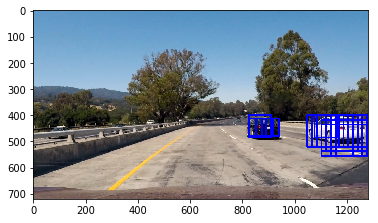

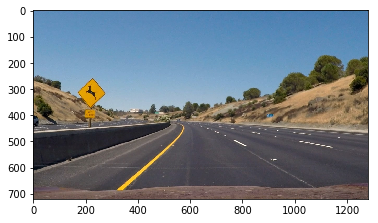

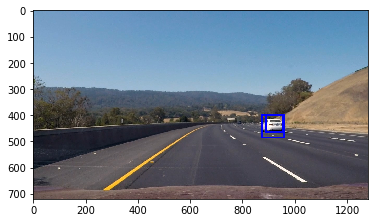

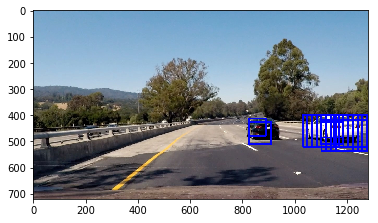

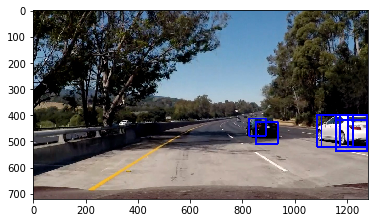

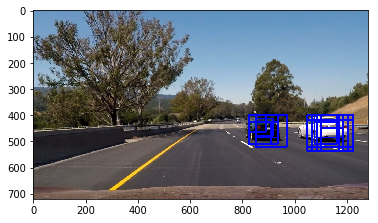

In [77]:
folder = './test_images/'
for img_ in os.listdir(folder):
    img = plt.imread(folder+img_)
    good_windows = find_good_windows(img)
    img_result = draw_boxes(img, good_windows)
    plt.imshow(img_result)
    plt.show()

In [80]:
img_result = draw_boxes(img, good_windows)

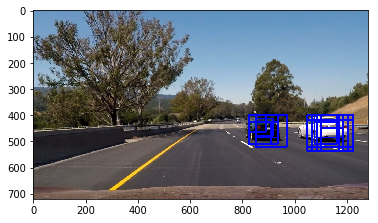

In [81]:
plt.imshow(img_result)

In [96]:
# Step 3: Create a heatmap of recurring detections frame by frame and follow detected vehicles using centroid of detection areas
def gen_heat_map(img, good_boxes, viz=False):
    heat_map = np.zeros_like(img[:,:,0]).astype(np.float32)
    for box in good_boxes:
        # box is (y1,x1),(y2,x2) -- y,x format chosen for opencv
        (y1,x1),(y2,x2) = box
        heat_map[x1:x2,y1:y2] += 1
    if viz:
        plt.imshow(heat_map, 'hot')
        plt.title('heat map')
    return heat_map
    

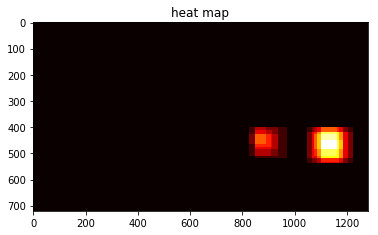

In [97]:
heat = gen_heat_map(img, good_windows, True)

In [98]:
# applies a threshold to the heat map
# this helps weed out false postives
def apply_thresh(heat_map, thresh='auto', auto_factor=1, viz=False):
    if thresh == 'auto': # if auto, uses the average intensity of only cells with detections
        # max() used to account for images with NO detections (div by 0 error prevention)
        thresh = np.sum(heat_map)/max(np.sum(heat_map > 0),1) * auto_factor
        print('threshold of ', str(thresh))
    
    bin_map = heat_map >= thresh
    
    if viz: 
        plt.imshow(bin_map,'hot')
        plt.title('heat map after thresholding')
    return bin_map
    

threshold of  4.57527833701


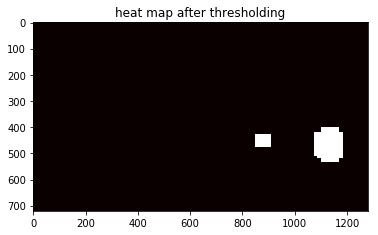

In [99]:
bin_img = apply_thresh(heat, thresh='auto',  viz=True)

### Step 4: Estimate a bounding box for detected vehicles



In [86]:
# takes in the binary image without the thresholds and estimates the bouding box for each vechicle
def get_bounding_boxes(img, bin_map, viz=False):
    # copy img
    img_copy = np.copy(img)
    # get unique regions
    labeled_img, region_count = label(bin_map)
    # viz
    if viz: plt.imshow(labeled_img); plt.title('Image with regions')
    # for each region_id create a bbox based on max and min x
    for region_id in range(1,region_count+1):
        # get the coords
        region_coords = np.nonzero(labeled_img == region_id)
        h,w = region_coords # h or x is vertical, w or y is horizontal
        # gen the coordinates of bbox (y,x) or (w,h) is opencv format
        top_left = (np.min(w), np.min(h)) # min h is higher than max h
        bottom_right = (np.max(w), np.max(h))
        if top_left == (0,0): continue # indicates there is no detection
        # another false positive removal step - assumes that small bounding boxes are false positives
        diagnol = np.sqrt((top_left[0] - bottom_right[0])**2 + (top_left[1] - bottom_right[1])**2) 
        print(diagnol)
        if bottom_right[1] > 600: 
            if diagnol <= 120: continue
        # draw the rectangle
        cv2.rectangle(img_copy, top_left, bottom_right, (0,255,0), 4)
        
    if viz: plt.imshow(img_copy); plt.title('Final Image with Vehicles Detected')
    
    return img_copy

In [87]:
img_copy = np.copy(img)
# get unique regions
labeled_img, region_count = label(bin_img)

In [88]:
region_count

2

173.366663462
78.6447709641


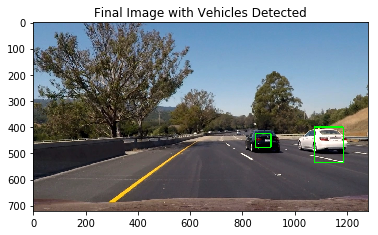

In [89]:
result = get_bounding_boxes(img, bin_img, True)

### Step 5: Pipeline to put it all together and run on video

In [90]:
save_errors = [] # save errors to look later

def vehicle_detection_pipeline(img):
    
    try:
        img_copy = np.copy(img)
        # sliding windows on image
        good_windows = find_good_windows(img_copy, viz=False)
        # generate a heatmap
        heat = gen_heat_map(img_copy, good_windows, viz=False)
        # apply a threshold to remove false positives
        thresh_img = apply_thresh(heat, thresh=1, viz=False)
        # generate final image with bouding boxes around vehicles
        final_img = get_bounding_boxes(img, thresh_img, viz=False)
        
    except Exception as e:
        print(e)
        save_errors.append(e)
    
    return final_img

143.22011032
274.870878778


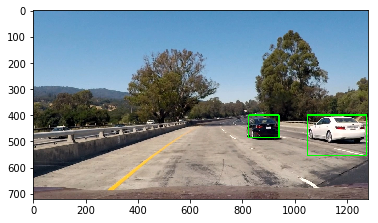

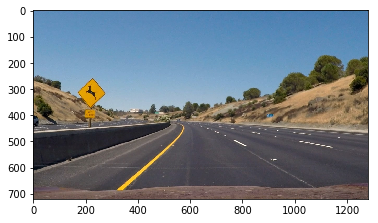

118.793939239


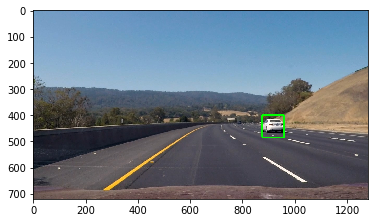

280.702689691
128.222462931


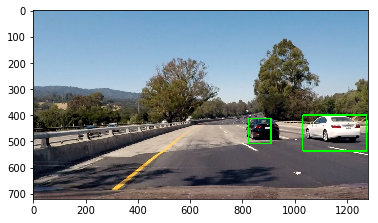

238.314917703
146.0


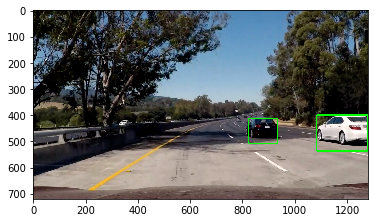

187.579316557
220.676233428


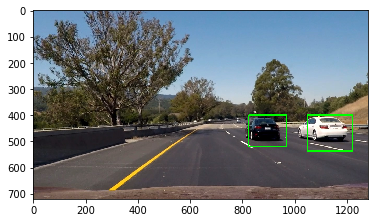

In [91]:
folder = './test_images/'
for img_ in os.listdir(folder):
    img = plt.imread(folder+img_)
    final_img = vehicle_detection_pipeline(img)
    plt.imshow(final_img)
    plt.show()

#### Run pipeline on video

In [65]:
#### APPLY PIPELINE TO VIDEO ####
output_video_file = './results/project_video_out.mp4'
input_video = VideoFileClip('./project_video.mp4')
#input_video = VideoFileClip('./project_video.mp4').subclip(20,30)
#input_video = VideoFileClip('./test_video.mp4')
output_video = input_video.fl_image(vehicle_detection_pipeline)
%time output_video.write_videofile(output_video_file, audio=False, fps=15)

[MoviePy] >>>> Building video ./test_new.mp4
[MoviePy] Writing video ./test_new.mp4



 12%|█████████▉                                                                       | 62/505 [05:49<41:01,  5.56s/it]

158.700976683



 12%|██████████                                                                       | 63/505 [05:54<40:56,  5.56s/it]

184.114095061



 13%|██████████▎                                                                      | 64/505 [06:00<40:51,  5.56s/it]

171.143214882



 13%|██████████▍                                                                      | 65/505 [06:05<40:46,  5.56s/it]

184.504742486



 13%|██████████▌                                                                      | 66/505 [06:11<40:45,  5.57s/it]

184.504742486



 13%|██████████▋                                                                      | 67/505 [06:17<40:41,  5.58s/it]

198.600100705



 13%|██████████▉                                                                      | 68/505 [06:22<40:39,  5.58s/it]

249.242853458



 14%|███████████                                                                      | 69/505 [06:28<40:34,  5.58s/it]

209.976189126



 14%|███████████▏                                                                     | 70/505 [06:33<40:29,  5.59s/it]

195.412384459



 14%|███████████▍                                                                     | 71/505 [06:39<40:26,  5.59s/it]

195.412384459



 14%|███████████▌                                                                     | 72/505 [06:44<40:22,  5.59s/it]

220.229425827



 14%|███████████▋                                                                     | 73/505 [06:50<40:25,  5.61s/it]

227.589542818



 15%|███████████▊                                                                     | 74/505 [06:56<40:19,  5.61s/it]

228.442552954



 15%|████████████                                                                     | 75/505 [07:01<40:16,  5.62s/it]

195.412384459



 15%|████████████▏                                                                    | 76/505 [07:07<40:07,  5.61s/it]

228.442552954



 15%|████████████▎                                                                    | 77/505 [07:13<40:03,  5.61s/it]

237.170824513



 15%|████████████▌                                                                    | 78/505 [07:18<39:52,  5.60s/it]

238.314917703



 16%|████████████▋                                                                    | 79/505 [07:24<39:53,  5.62s/it]

228.442552954



 16%|████████████▊                                                                    | 80/505 [07:29<39:41,  5.60s/it]

253.254812393



 16%|████████████▉                                                                    | 81/505 [07:35<39:31,  5.59s/it]

253.254812393



 16%|█████████████▏                                                                   | 82/505 [07:41<39:20,  5.58s/it]

253.254812393



 16%|█████████████▎                                                                   | 83/505 [07:46<39:12,  5.57s/it]

253.254812393



 17%|█████████████▍                                                                   | 84/505 [07:52<39:04,  5.57s/it]

268.570288751



 17%|█████████████▋                                                                   | 85/505 [07:57<38:59,  5.57s/it]

268.570288751



 17%|█████████████▊                                                                   | 86/505 [08:03<38:51,  5.56s/it]

278.183392747



 17%|█████████████▉                                                                   | 87/505 [08:08<38:50,  5.57s/it]

278.183392747



 17%|██████████████                                                                   | 88/505 [08:14<38:44,  5.57s/it]

268.570288751



 18%|██████████████▎                                                                  | 89/505 [08:20<38:37,  5.57s/it]

268.570288751



 18%|██████████████▍                                                                  | 90/505 [08:25<38:34,  5.58s/it]

265.137700073



 18%|██████████████▌                                                                  | 91/505 [08:31<38:30,  5.58s/it]

265.137700073



 18%|██████████████▊                                                                  | 92/505 [08:36<38:23,  5.58s/it]

265.137700073



 18%|██████████████▉                                                                  | 93/505 [08:42<38:18,  5.58s/it]

265.994360842



 19%|███████████████                                                                  | 94/505 [08:47<38:11,  5.57s/it]

284.200633356



 19%|███████████████▏                                                                 | 95/505 [08:53<38:03,  5.57s/it]

281.575922266



 19%|███████████████▍                                                                 | 96/505 [08:59<37:55,  5.56s/it]

284.200633356



 19%|███████████████▌                                                                 | 97/505 [09:04<37:54,  5.57s/it]

284.200633356



 19%|███████████████▋                                                                 | 98/505 [09:10<37:49,  5.57s/it]

284.200633356



 20%|███████████████▉                                                                 | 99/505 [09:15<37:43,  5.58s/it]

284.200633356



 20%|███████████████▊                                                                | 100/505 [09:21<37:37,  5.57s/it]

296.543420092



 20%|████████████████                                                                | 101/505 [09:26<37:36,  5.58s/it]

296.543420092



 20%|████████████████▏                                                               | 102/505 [09:32<37:29,  5.58s/it]

333.444148247



 20%|████████████████▎                                                               | 103/505 [09:38<37:21,  5.58s/it]

296.543420092



 21%|████████████████▍                                                               | 104/505 [09:43<37:17,  5.58s/it]

296.543420092



 21%|████████████████▋                                                               | 105/505 [09:49<37:13,  5.58s/it]

303.66099519



 21%|████████████████▊                                                               | 106/505 [09:54<37:05,  5.58s/it]

296.543420092



 21%|████████████████▉                                                               | 107/505 [10:00<37:00,  5.58s/it]

280.702689691



 21%|█████████████████                                                               | 108/505 [10:05<36:54,  5.58s/it]

280.702689691



 22%|█████████████████▎                                                              | 109/505 [10:11<36:46,  5.57s/it]

280.702689691



 22%|█████████████████▍                                                              | 110/505 [10:17<36:42,  5.58s/it]

280.702689691



 22%|█████████████████▌                                                              | 111/505 [10:22<36:38,  5.58s/it]

249.899979992



 22%|█████████████████▋                                                              | 112/505 [10:28<36:38,  5.60s/it]

255.783111249



 22%|█████████████████▉                                                              | 113/505 [10:33<36:32,  5.59s/it]

271.154937259



 23%|██████████████████                                                              | 114/505 [10:39<36:24,  5.59s/it]

280.702689691



 23%|██████████████████▏                                                             | 115/505 [10:45<36:18,  5.59s/it]

280.702689691



 23%|██████████████████▍                                                             | 116/505 [10:50<36:23,  5.61s/it]

280.702689691



 23%|██████████████████▌                                                             | 117/505 [10:56<36:27,  5.64s/it]

280.702689691



 23%|██████████████████▋                                                             | 118/505 [11:02<36:27,  5.65s/it]

280.702689691



 24%|██████████████████▊                                                             | 119/505 [11:07<36:14,  5.63s/it]

265.137700073



 24%|███████████████████                                                             | 120/505 [11:13<36:02,  5.62s/it]

265.137700073



 24%|███████████████████▏                                                            | 121/505 [11:18<35:50,  5.60s/it]

265.137700073



 24%|███████████████████▎                                                            | 122/505 [11:24<35:45,  5.60s/it]

265.137700073



 24%|███████████████████▍                                                            | 123/505 [11:30<35:38,  5.60s/it]

265.137700073



 25%|███████████████████▋                                                            | 124/505 [11:35<35:36,  5.61s/it]

280.702689691



 25%|███████████████████▊                                                            | 125/505 [11:41<35:30,  5.61s/it]

265.137700073



 25%|███████████████████▉                                                            | 126/505 [11:46<35:18,  5.59s/it]

240.503638226



 25%|████████████████████                                                            | 127/505 [11:52<35:10,  5.58s/it]

315.317300509



 25%|████████████████████▎                                                           | 128/505 [11:57<35:01,  5.58s/it]

249.899979992



 26%|████████████████████▍                                                           | 129/505 [12:03<34:56,  5.57s/it]

249.899979992



 26%|████████████████████▌                                                           | 130/505 [12:09<34:52,  5.58s/it]

265.137700073



 26%|████████████████████▊                                                           | 131/505 [12:14<34:48,  5.58s/it]

265.137700073



 26%|████████████████████▉                                                           | 132/505 [12:20<34:42,  5.58s/it]

256.300604759



 26%|█████████████████████                                                           | 133/505 [12:25<34:43,  5.60s/it]

256.300604759



 27%|█████████████████████▏                                                          | 134/505 [12:31<34:33,  5.59s/it]

265.137700073



 27%|█████████████████████▍                                                          | 135/505 [12:37<34:22,  5.57s/it]

240.503638226



 27%|█████████████████████▌                                                          | 136/505 [12:42<34:12,  5.56s/it]

240.503638226



 27%|█████████████████████▋                                                          | 137/505 [12:48<34:13,  5.58s/it]

240.503638226



 27%|█████████████████████▊                                                          | 138/505 [12:53<34:02,  5.57s/it]

235.053185471



 28%|██████████████████████                                                          | 139/505 [12:59<33:55,  5.56s/it]

249.899979992



 28%|██████████████████████▏                                                         | 140/505 [13:04<33:52,  5.57s/it]

240.503638226



 28%|██████████████████████▎                                                         | 141/505 [13:10<33:42,  5.56s/it]

276.877229111



 28%|██████████████████████▍                                                         | 142/505 [13:16<33:44,  5.58s/it]

231.866340809



 28%|██████████████████████▋                                                         | 143/505 [13:21<33:38,  5.58s/it]

235.053185471



 29%|██████████████████████▊                                                         | 144/505 [13:27<33:28,  5.56s/it]

229.296750958



 29%|██████████████████████▉                                                         | 145/505 [13:32<33:23,  5.56s/it]

232.725159792



 29%|███████████████████████▏                                                        | 146/505 [13:38<33:17,  5.56s/it]

217.451143938



 29%|███████████████████████▎                                                        | 147/505 [13:43<33:14,  5.57s/it]

232.725159792



 29%|███████████████████████▍                                                        | 148/505 [13:49<33:08,  5.57s/it]

311.616751796



 30%|███████████████████████▌                                                        | 149/505 [13:54<33:01,  5.57s/it]

213.283848427



 30%|███████████████████████▊                                                        | 150/505 [14:00<32:55,  5.56s/it]

213.283848427
118.793939239



 30%|███████████████████████▉                                                        | 151/505 [14:06<32:49,  5.56s/it]

277.780488876



 30%|████████████████████████                                                        | 152/505 [14:11<32:43,  5.56s/it]

203.435493462



 30%|████████████████████████▏                                                       | 153/505 [14:17<32:40,  5.57s/it]

243.115199031



 30%|████████████████████████▍                                                       | 154/505 [14:22<32:37,  5.58s/it]

212.454701054



 31%|████████████████████████▌                                                       | 155/505 [14:28<32:29,  5.57s/it]

206.693009074



 31%|████████████████████████▋                                                       | 156/505 [14:33<32:23,  5.57s/it]

189.129585205



 31%|████████████████████████▊                                                       | 157/505 [14:39<32:14,  5.56s/it]

212.454701054



 31%|█████████████████████████                                                       | 158/505 [14:45<32:09,  5.56s/it]

211.62703041



 31%|█████████████████████████▏                                                      | 159/505 [14:50<32:04,  5.56s/it]

206.693009074



 32%|█████████████████████████▎                                                      | 160/505 [14:56<32:00,  5.57s/it]

197.800404449



 32%|█████████████████████████▌                                                      | 161/505 [15:01<31:53,  5.56s/it]

183.741666478



 32%|█████████████████████████▋                                                      | 162/505 [15:07<31:46,  5.56s/it]

209.976189126



 32%|█████████████████████████▊                                                      | 163/505 [15:12<31:41,  5.56s/it]

229.427548477



 32%|█████████████████████████▉                                                      | 164/505 [15:18<31:37,  5.56s/it]

193.041446327



 33%|██████████████████████████▏                                                     | 165/505 [15:24<31:31,  5.56s/it]

168.600118624



 33%|██████████████████████████▎                                                     | 166/505 [15:29<31:25,  5.56s/it]

237.901240014



 33%|██████████████████████████▍                                                     | 167/505 [15:35<31:20,  5.56s/it]

193.041446327



 33%|██████████████████████████▌                                                     | 168/505 [15:40<31:15,  5.57s/it]

182.49657531



 33%|██████████████████████████▊                                                     | 169/505 [15:46<31:10,  5.57s/it]

182.49657531



 34%|██████████████████████████▉                                                     | 170/505 [15:51<31:05,  5.57s/it]

227.633477327
104.809350728



 34%|███████████████████████████                                                     | 171/505 [15:57<31:01,  5.57s/it]

182.49657531
90.5096679919



 34%|███████████████████████████▏                                                    | 172/505 [16:03<30:54,  5.57s/it]

159.0
144.844744468



 34%|███████████████████████████▍                                                    | 173/505 [16:08<30:50,  5.58s/it]

179.961106909
118.793939239



 34%|███████████████████████████▌                                                    | 174/505 [16:14<30:44,  5.57s/it]

159.0



 35%|███████████████████████████▋                                                    | 175/505 [16:19<30:38,  5.57s/it]

168.600118624



 35%|███████████████████████████▉                                                    | 176/505 [16:25<30:33,  5.57s/it]

168.600118624



 35%|████████████████████████████                                                    | 177/505 [16:30<30:27,  5.57s/it]

159.0



 35%|████████████████████████████▏                                                   | 178/505 [16:36<30:20,  5.57s/it]

182.49657531



 35%|████████████████████████████▎                                                   | 179/505 [16:42<30:15,  5.57s/it]

159.0



 36%|████████████████████████████▌                                                   | 180/505 [16:47<30:10,  5.57s/it]

179.961106909



 36%|████████████████████████████▋                                                   | 181/505 [16:53<30:04,  5.57s/it]

168.600118624



 36%|████████████████████████████▊                                                   | 182/505 [16:58<29:58,  5.57s/it]

182.49657531



 36%|████████████████████████████▉                                                   | 183/505 [17:04<29:52,  5.57s/it]

168.600118624



 36%|█████████████████████████████▏                                                  | 184/505 [17:09<29:46,  5.56s/it]

168.600118624



 37%|█████████████████████████████▎                                                  | 185/505 [17:15<29:40,  5.56s/it]

193.041446327



 37%|█████████████████████████████▍                                                  | 186/505 [17:20<29:36,  5.57s/it]

179.961106909



 37%|█████████████████████████████▌                                                  | 187/505 [17:26<29:31,  5.57s/it]

174.771279105



 37%|█████████████████████████████▊                                                  | 188/505 [17:32<29:24,  5.57s/it]

193.041446327



 37%|█████████████████████████████▉                                                  | 189/505 [17:37<29:18,  5.57s/it]

179.961106909



 38%|██████████████████████████████                                                  | 190/505 [17:43<29:12,  5.56s/it]

168.600118624



 38%|██████████████████████████████▎                                                 | 191/505 [17:48<29:08,  5.57s/it]

182.49657531



 38%|██████████████████████████████▍                                                 | 192/505 [17:54<29:02,  5.57s/it]

173.666346769



 38%|██████████████████████████████▌                                                 | 193/505 [17:59<28:56,  5.56s/it]

173.666346769



 38%|██████████████████████████████▋                                                 | 194/505 [18:05<28:49,  5.56s/it]

159.0



 39%|██████████████████████████████▉                                                 | 195/505 [18:11<28:46,  5.57s/it]

179.961106909
109.343495463



 39%|███████████████████████████████                                                 | 196/505 [18:16<28:39,  5.57s/it]

131.365901207
168.291413922



 39%|███████████████████████████████▏                                                | 197/505 [18:22<28:36,  5.57s/it]

159.0



 39%|███████████████████████████████▎                                                | 198/505 [18:27<28:29,  5.57s/it]

159.0



 39%|███████████████████████████████▌                                                | 199/505 [18:33<28:23,  5.57s/it]

168.600118624
133.304163476



 40%|███████████████████████████████▋                                                | 200/505 [18:38<28:18,  5.57s/it]

144.844744468



 40%|███████████████████████████████▊                                                | 201/505 [18:44<28:13,  5.57s/it]

144.844744468



 40%|████████████████████████████████                                                | 202/505 [18:50<28:06,  5.57s/it]

144.844744468



 40%|████████████████████████████████▏                                               | 203/505 [18:55<28:00,  5.57s/it]

118.793939239



 40%|████████████████████████████████▎                                               | 204/505 [19:01<27:55,  5.57s/it]

142.8355698



 41%|████████████████████████████████▍                                               | 205/505 [19:06<27:49,  5.56s/it]

137.97463535



 41%|████████████████████████████████▋                                               | 206/505 [19:12<27:43,  5.56s/it]

155.32224567



 41%|████████████████████████████████▊                                               | 207/505 [19:17<27:39,  5.57s/it]

140.801278403



 41%|████████████████████████████████▉                                               | 208/505 [19:23<27:33,  5.57s/it]

126.063476075



 41%|█████████████████████████████████                                               | 209/505 [19:29<27:28,  5.57s/it]

118.793939239



 42%|█████████████████████████████████▎                                              | 210/505 [19:34<27:22,  5.57s/it]

144.844744468



 42%|█████████████████████████████████▍                                              | 211/505 [19:40<27:17,  5.57s/it]

144.844744468



 42%|█████████████████████████████████▌                                              | 212/505 [19:45<27:11,  5.57s/it]

144.844744468



 42%|█████████████████████████████████▋                                              | 213/505 [19:51<27:05,  5.57s/it]

155.32224567



 42%|█████████████████████████████████▉                                              | 214/505 [19:56<27:00,  5.57s/it]

168.291413922



 43%|██████████████████████████████████                                              | 215/505 [20:02<26:53,  5.56s/it]

155.32224567



 43%|██████████████████████████████████▏                                             | 216/505 [20:08<26:50,  5.57s/it]

168.291413922



 43%|██████████████████████████████████▍                                             | 217/505 [20:13<26:44,  5.57s/it]

209.976189126



 43%|██████████████████████████████████▌                                             | 218/505 [20:19<26:37,  5.57s/it]

151.558569537



 43%|██████████████████████████████████▋                                             | 219/505 [20:24<26:34,  5.57s/it]

144.844744468



 44%|██████████████████████████████████▊                                             | 220/505 [20:30<26:28,  5.57s/it]

144.844744468



 44%|███████████████████████████████████                                             | 221/505 [20:35<26:20,  5.56s/it]

144.844744468



 44%|███████████████████████████████████▏                                            | 222/505 [20:41<26:15,  5.57s/it]

155.32224567



 44%|███████████████████████████████████▎                                            | 223/505 [20:46<26:11,  5.57s/it]

137.97463535



 44%|███████████████████████████████████▍                                            | 224/505 [20:52<26:04,  5.57s/it]

90.5096679919



 45%|███████████████████████████████████▋                                            | 225/505 [20:58<25:58,  5.57s/it]

104.809350728



 45%|███████████████████████████████████▊                                            | 226/505 [21:03<25:52,  5.56s/it]

144.844744468



 45%|███████████████████████████████████▉                                            | 227/505 [21:09<25:48,  5.57s/it]

180.712478816



 45%|████████████████████████████████████                                            | 228/505 [21:14<25:42,  5.57s/it]

118.793939239



 45%|████████████████████████████████████▎                                           | 229/505 [21:20<25:32,  5.55s/it]

118.793939239



 46%|████████████████████████████████████▉                                           | 233/505 [21:42<25:09,  5.55s/it]

131.365901207



 46%|█████████████████████████████████████                                           | 234/505 [21:48<25:04,  5.55s/it]

118.793939239



 47%|█████████████████████████████████████▏                                          | 235/505 [21:53<25:00,  5.56s/it]

118.793939239



 47%|█████████████████████████████████████▋                                          | 238/505 [22:10<24:42,  5.55s/it]

118.793939239



 47%|█████████████████████████████████████▊                                          | 239/505 [22:15<24:37,  5.55s/it]

131.365901207



 48%|██████████████████████████████████████▎                                         | 242/505 [22:32<24:20,  5.55s/it]

168.291413922



 49%|███████████████████████████████████████▏                                        | 247/505 [23:00<23:53,  5.55s/it]

118.793939239



 50%|███████████████████████████████████████▉                                        | 252/505 [23:28<23:25,  5.56s/it]

90.5096679919



 50%|████████████████████████████████████████▍                                       | 255/505 [23:44<23:09,  5.56s/it]

118.793939239



 51%|████████████████████████████████████████▋                                       | 257/505 [23:55<22:58,  5.56s/it]

118.793939239



 51%|████████████████████████████████████████▊                                       | 258/505 [24:01<22:51,  5.55s/it]

90.5096679919



 52%|█████████████████████████████████████████▌                                      | 262/505 [24:23<22:30,  5.56s/it]

120.216471417



 52%|█████████████████████████████████████████▋                                      | 263/505 [24:29<22:25,  5.56s/it]

118.793939239



 52%|█████████████████████████████████████████▊                                      | 264/505 [24:34<22:19,  5.56s/it]

90.5096679919



 53%|██████████████████████████████████████████▍                                     | 268/505 [24:56<21:55,  5.55s/it]

118.793939239



 53%|██████████████████████████████████████████▌                                     | 269/505 [25:02<21:49,  5.55s/it]

118.793939239



 54%|██████████████████████████████████████████▉                                     | 271/505 [25:13<21:38,  5.55s/it]

90.5096679919



 54%|███████████████████████████████████████████                                     | 272/505 [25:19<21:32,  5.55s/it]

118.793939239



 54%|███████████████████████████████████████████▏                                    | 273/505 [25:24<21:28,  5.55s/it]

90.5096679919



 54%|███████████████████████████████████████████▍                                    | 274/505 [25:30<21:21,  5.55s/it]

90.5096679919



 55%|███████████████████████████████████████████▋                                    | 276/505 [25:41<21:12,  5.56s/it]

90.5096679919



 55%|███████████████████████████████████████████▉                                    | 277/505 [25:46<21:06,  5.56s/it]

90.5096679919



 55%|████████████████████████████████████████████                                    | 278/505 [25:52<21:00,  5.56s/it]

118.793939239



 55%|████████████████████████████████████████████▏                                   | 279/505 [25:58<20:57,  5.56s/it]

90.5096679919



 55%|████████████████████████████████████████████▎                                   | 280/505 [26:03<20:51,  5.56s/it]

90.5096679919



 56%|████████████████████████████████████████████▌                                   | 281/505 [26:09<20:45,  5.56s/it]

90.5096679919
196.814633602



 56%|████████████████████████████████████████████▋                                   | 282/505 [26:14<20:38,  5.55s/it]

90.5096679919
196.596032513



 56%|████████████████████████████████████████████▊                                   | 283/505 [26:20<20:33,  5.56s/it]

90.5096679919
206.8671071



 56%|████████████████████████████████████████████▉                                   | 284/505 [26:25<20:31,  5.57s/it]

90.5096679919
206.8671071



 56%|█████████████████████████████████████████████▏                                  | 285/505 [26:31<20:25,  5.57s/it]

118.793939239
181.466250306



 57%|█████████████████████████████████████████████▎                                  | 286/505 [26:37<20:19,  5.57s/it]

90.5096679919
244.88364584



 57%|█████████████████████████████████████████████▍                                  | 287/505 [26:42<20:14,  5.57s/it]

90.5096679919
181.466250306



 57%|█████████████████████████████████████████████▌                                  | 288/505 [26:48<20:08,  5.57s/it]

90.5096679919
311.284435846



 57%|█████████████████████████████████████████████▊                                  | 289/505 [26:53<20:03,  5.57s/it]

90.5096679919
323.867256758



 57%|█████████████████████████████████████████████▉                                  | 290/505 [26:59<20:00,  5.59s/it]

90.5096679919
323.867256758



 58%|██████████████████████████████████████████████                                  | 291/505 [27:04<19:56,  5.59s/it]

118.793939239
336.94213153



 58%|██████████████████████████████████████████████▎                                 | 292/505 [27:10<19:50,  5.59s/it]

118.793939239
378.600052826



 58%|██████████████████████████████████████████████▍                                 | 293/505 [27:16<19:44,  5.59s/it]

118.793939239
350.453991274



 58%|██████████████████████████████████████████████▌                                 | 294/505 [27:21<19:39,  5.59s/it]

118.793939239
335.931540645



 58%|██████████████████████████████████████████████▋                                 | 295/505 [27:27<19:32,  5.58s/it]

118.793939239
296.664794002



 59%|██████████████████████████████████████████████▉                                 | 296/505 [27:32<19:26,  5.58s/it]

120.216471417
351.005697959



 59%|███████████████████████████████████████████████                                 | 297/505 [27:38<19:20,  5.58s/it]

120.216471417
308.561177078



 59%|███████████████████████████████████████████████▏                                | 298/505 [27:44<19:13,  5.57s/it]

120.216471417
330.727984906



 59%|███████████████████████████████████████████████▎                                | 299/505 [27:49<19:07,  5.57s/it]

120.216471417
325.627087325



 59%|███████████████████████████████████████████████▌                                | 300/505 [27:55<19:02,  5.57s/it]

452.306312138



 60%|███████████████████████████████████████████████▋                                | 301/505 [28:00<18:56,  5.57s/it]

169.0
301.559281071



 60%|███████████████████████████████████████████████▊                                | 302/505 [28:06<18:49,  5.57s/it]

118.793939239
270.114790413



 60%|████████████████████████████████████████████████                                | 303/505 [28:11<18:44,  5.57s/it]

118.793939239
310.654148532



 60%|████████████████████████████████████████████████▏                               | 304/505 [28:17<18:38,  5.57s/it]

385.624169367



 60%|████████████████████████████████████████████████▎                               | 305/505 [28:22<18:33,  5.57s/it]

131.365901207
303.199604221



 61%|████████████████████████████████████████████████▍                               | 306/505 [28:28<18:27,  5.56s/it]

377.033155041



 61%|████████████████████████████████████████████████▋                               | 307/505 [28:34<18:21,  5.56s/it]

345.441746174



 61%|████████████████████████████████████████████████▊                               | 308/505 [28:39<18:16,  5.56s/it]

379.697247817



 61%|████████████████████████████████████████████████▉                               | 309/505 [28:45<18:10,  5.56s/it]

377.033155041



 61%|█████████████████████████████████████████████████                               | 310/505 [28:50<18:05,  5.57s/it]

357.36396013



 62%|█████████████████████████████████████████████████▎                              | 311/505 [28:56<17:59,  5.57s/it]

341.12314492



 62%|█████████████████████████████████████████████████▍                              | 312/505 [29:01<17:53,  5.56s/it]

303.222690444



 62%|█████████████████████████████████████████████████▌                              | 313/505 [29:07<17:48,  5.57s/it]

314.798348153



 62%|█████████████████████████████████████████████████▋                              | 314/505 [29:13<17:41,  5.56s/it]

307.865230255



 62%|█████████████████████████████████████████████████▉                              | 315/505 [29:18<17:36,  5.56s/it]

245.464865103



 63%|██████████████████████████████████████████████████                              | 316/505 [29:24<17:31,  5.56s/it]

281.192105152



 63%|██████████████████████████████████████████████████▏                             | 317/505 [29:29<17:26,  5.57s/it]

272.882758708



 63%|██████████████████████████████████████████████████▍                             | 318/505 [29:35<17:20,  5.56s/it]

281.192105152



 63%|██████████████████████████████████████████████████▌                             | 319/505 [29:40<17:14,  5.56s/it]

266.510787774



 63%|██████████████████████████████████████████████████▋                             | 320/505 [29:46<17:10,  5.57s/it]

260.203766306



 64%|██████████████████████████████████████████████████▊                             | 321/505 [29:52<17:04,  5.57s/it]

274.870878778



 64%|███████████████████████████████████████████████████                             | 322/505 [29:57<16:58,  5.57s/it]

274.870878778



 64%|███████████████████████████████████████████████████▏                            | 323/505 [30:03<16:51,  5.56s/it]

274.870878778



 64%|███████████████████████████████████████████████████▎                            | 324/505 [30:08<16:49,  5.58s/it]

260.203766306



 64%|███████████████████████████████████████████████████▍                            | 325/505 [30:14<16:44,  5.58s/it]

265.137700073



 65%|███████████████████████████████████████████████████▋                            | 326/505 [30:19<16:37,  5.57s/it]

274.870878778



 65%|███████████████████████████████████████████████████▊                            | 327/505 [30:25<16:34,  5.59s/it]

249.899979992



 65%|███████████████████████████████████████████████████▉                            | 328/505 [30:31<16:31,  5.60s/it]

260.203766306



 65%|████████████████████████████████████████████████████                            | 329/505 [30:36<16:26,  5.60s/it]

249.899979992



 65%|████████████████████████████████████████████████████▎                           | 330/505 [30:42<16:18,  5.59s/it]

260.203766306



 66%|████████████████████████████████████████████████████▍                           | 331/505 [30:47<16:11,  5.58s/it]

260.203766306



 66%|████████████████████████████████████████████████████▌                           | 332/505 [30:53<16:04,  5.57s/it]

235.053185471



 66%|████████████████████████████████████████████████████▊                           | 333/505 [30:59<15:59,  5.58s/it]

235.053185471



 66%|████████████████████████████████████████████████████▉                           | 334/505 [31:04<15:55,  5.59s/it]

249.899979992



 66%|█████████████████████████████████████████████████████                           | 335/505 [31:10<15:49,  5.59s/it]

249.899979992



 67%|█████████████████████████████████████████████████████▏                          | 336/505 [31:15<15:42,  5.58s/it]

249.899979992



 67%|█████████████████████████████████████████████████████▍                          | 337/505 [31:21<15:36,  5.58s/it]

235.053185471



 67%|█████████████████████████████████████████████████████▌                          | 338/505 [31:26<15:31,  5.58s/it]

235.053185471



 67%|█████████████████████████████████████████████████████▋                          | 339/505 [31:32<15:25,  5.58s/it]

235.053185471



 67%|█████████████████████████████████████████████████████▊                          | 340/505 [31:38<15:19,  5.57s/it]

235.053185471



 68%|██████████████████████████████████████████████████████                          | 341/505 [31:43<15:13,  5.57s/it]

235.053185471



 68%|██████████████████████████████████████████████████████▏                         | 342/505 [31:49<15:07,  5.57s/it]

220.676233428



 68%|██████████████████████████████████████████████████████▎                         | 343/505 [31:54<15:02,  5.57s/it]

254.93920844



 68%|██████████████████████████████████████████████████████▍                         | 344/505 [32:00<14:57,  5.57s/it]

220.676233428



 68%|██████████████████████████████████████████████████████▋                         | 345/505 [32:05<14:51,  5.57s/it]

246.564393212



 69%|██████████████████████████████████████████████████████▊                         | 346/505 [32:11<14:48,  5.59s/it]

260.869699275



 69%|██████████████████████████████████████████████████████▉                         | 347/505 [32:17<14:41,  5.58s/it]

260.869699275



 69%|███████████████████████████████████████████████████████▏                        | 348/505 [32:22<14:37,  5.59s/it]

273.748059354



 69%|███████████████████████████████████████████████████████▎                        | 349/505 [32:28<14:32,  5.60s/it]

260.869699275



 69%|███████████████████████████████████████████████████████▍                        | 350/505 [32:33<14:25,  5.58s/it]

260.869699275



 70%|███████████████████████████████████████████████████████▌                        | 351/505 [32:39<14:19,  5.58s/it]

260.869699275



 70%|███████████████████████████████████████████████████████▊                        | 352/505 [32:45<14:12,  5.57s/it]

273.748059354



 70%|███████████████████████████████████████████████████████▉                        | 353/505 [32:50<14:07,  5.57s/it]

251.882909305



 70%|████████████████████████████████████████████████████████                        | 354/505 [32:56<14:01,  5.57s/it]

265.198039208



 70%|████████████████████████████████████████████████████████▏                       | 355/505 [33:01<13:55,  5.57s/it]

256.300604759



 70%|████████████████████████████████████████████████████████▍                       | 356/505 [33:07<13:50,  5.57s/it]

285.029823001



 71%|████████████████████████████████████████████████████████▌                       | 357/505 [33:12<13:44,  5.57s/it]

295.976350407



 71%|████████████████████████████████████████████████████████▋                       | 358/505 [33:18<13:38,  5.57s/it]

295.976350407



 71%|████████████████████████████████████████████████████████▊                       | 359/505 [33:23<13:32,  5.57s/it]

295.976350407



 71%|█████████████████████████████████████████████████████████                       | 360/505 [33:29<13:27,  5.57s/it]

295.976350407



 71%|█████████████████████████████████████████████████████████▏                      | 361/505 [33:35<13:21,  5.57s/it]

295.976350407



 72%|█████████████████████████████████████████████████████████▎                      | 362/505 [33:40<13:16,  5.57s/it]

311.616751796



 72%|█████████████████████████████████████████████████████████▌                      | 363/505 [33:46<13:10,  5.57s/it]

311.616751796



 72%|█████████████████████████████████████████████████████████▋                      | 364/505 [33:51<13:04,  5.57s/it]

311.616751796



 72%|█████████████████████████████████████████████████████████▊                      | 365/505 [33:57<12:58,  5.56s/it]

311.616751796



 72%|█████████████████████████████████████████████████████████▉                      | 366/505 [34:02<12:53,  5.56s/it]

318.097469339



 73%|██████████████████████████████████████████████████████████▏                     | 367/505 [34:08<12:48,  5.57s/it]

341.669430883



 73%|██████████████████████████████████████████████████████████▎                     | 368/505 [34:14<12:42,  5.57s/it]

311.616751796



 73%|██████████████████████████████████████████████████████████▍                     | 369/505 [34:19<12:37,  5.57s/it]

327.392730524



 73%|██████████████████████████████████████████████████████████▌                     | 370/505 [34:25<12:33,  5.58s/it]

205.876176378
199.401604808



 73%|██████████████████████████████████████████████████████████▊                     | 371/505 [34:30<12:27,  5.58s/it]

343.285595387



 74%|██████████████████████████████████████████████████████████▉                     | 372/505 [34:36<12:20,  5.57s/it]

205.876176378
209.976189126



 74%|███████████████████████████████████████████████████████████                     | 373/505 [34:42<12:16,  5.58s/it]

192.426609387
217.451143938



 74%|███████████████████████████████████████████████████████████▏                    | 374/505 [34:47<12:10,  5.57s/it]

220.809872968
159.0



 74%|███████████████████████████████████████████████████████████▍                    | 375/505 [34:53<12:04,  5.58s/it]

205.876176378
159.0



 74%|███████████████████████████████████████████████████████████▌                    | 376/505 [34:58<11:58,  5.57s/it]

205.876176378
201.816748562



 75%|███████████████████████████████████████████████████████████▋                    | 377/505 [35:04<11:52,  5.57s/it]

205.876176378
225.410736213



 75%|███████████████████████████████████████████████████████████▉                    | 378/505 [35:09<11:46,  5.57s/it]

205.876176378
225.037774607



 75%|████████████████████████████████████████████████████████████                    | 379/505 [35:15<11:41,  5.57s/it]

239.954162289
159.0



 75%|████████████████████████████████████████████████████████████▏                   | 380/505 [35:20<11:35,  5.57s/it]

205.876176378
220.809872968



 75%|████████████████████████████████████████████████████████████▎                   | 381/505 [35:26<11:30,  5.57s/it]

205.876176378
215.779980536



 76%|████████████████████████████████████████████████████████████▌                   | 382/505 [35:32<11:24,  5.57s/it]

205.876176378
240.775829352



 76%|████████████████████████████████████████████████████████████▋                   | 383/505 [35:37<11:19,  5.57s/it]

231.008657846
159.0



 76%|████████████████████████████████████████████████████████████▊                   | 384/505 [35:43<11:13,  5.57s/it]

179.301422192
240.775829352



 76%|████████████████████████████████████████████████████████████▉                   | 385/505 [35:48<11:08,  5.57s/it]

195.412384459
159.0



 76%|█████████████████████████████████████████████████████████████▏                  | 386/505 [35:54<11:02,  5.57s/it]

268.570288751
168.600118624



 77%|█████████████████████████████████████████████████████████████▎                  | 387/505 [35:59<10:57,  5.57s/it]

241.598841057
159.0



 77%|█████████████████████████████████████████████████████████████▍                  | 388/505 [36:05<10:51,  5.57s/it]

157.613451203
239.13385373



 77%|█████████████████████████████████████████████████████████████▌                  | 389/505 [36:11<10:44,  5.56s/it]

259.849956706
144.844744468



 77%|█████████████████████████████████████████████████████████████▊                  | 390/505 [36:16<10:39,  5.56s/it]

256.300604759
147.299015611



 77%|█████████████████████████████████████████████████████████████▉                  | 391/505 [36:22<10:35,  5.57s/it]

194.620142842
240.503638226



 78%|██████████████████████████████████████████████████████████████                  | 392/505 [36:27<10:29,  5.57s/it]

192.255038946
249.899979992



 78%|██████████████████████████████████████████████████████████████▎                 | 393/505 [36:33<10:23,  5.57s/it]

225.037774607
157.613451203



 78%|██████████████████████████████████████████████████████████████▍                 | 394/505 [36:38<10:18,  5.57s/it]

194.620142842
243.115199031



 78%|██████████████████████████████████████████████████████████████▌                 | 395/505 [36:44<10:13,  5.58s/it]

194.620142842
243.115199031



 78%|██████████████████████████████████████████████████████████████▋                 | 396/505 [36:50<10:08,  5.58s/it]

155.32224567
249.899979992



 79%|██████████████████████████████████████████████████████████████▉                 | 397/505 [36:55<10:01,  5.57s/it]

280.702689691
155.32224567



 79%|███████████████████████████████████████████████████████████████                 | 398/505 [37:01<09:55,  5.57s/it]

168.600118624
265.137700073



 79%|███████████████████████████████████████████████████████████████▏                | 399/505 [37:06<09:50,  5.57s/it]

265.994360842
144.844744468



 79%|███████████████████████████████████████████████████████████████▎                | 400/505 [37:12<09:44,  5.57s/it]

268.570288751
133.686199737



 79%|███████████████████████████████████████████████████████████████▌                | 401/505 [37:18<09:42,  5.60s/it]

155.32224567
278.183392747



 80%|███████████████████████████████████████████████████████████████▋                | 402/505 [37:23<09:36,  5.60s/it]

155.32224567
253.254812393



 80%|███████████████████████████████████████████████████████████████▊                | 403/505 [37:29<09:30,  5.59s/it]

155.32224567
250.736913916



 80%|████████████████████████████████████████████████████████████████                | 404/505 [37:34<09:25,  5.60s/it]

250.736913916
147.299015611



 80%|████████████████████████████████████████████████████████████████▏               | 405/505 [37:40<09:20,  5.61s/it]

142.8355698
253.254812393



 80%|████████████████████████████████████████████████████████████████▎               | 406/505 [37:46<09:14,  5.60s/it]

157.613451203
253.254812393



 81%|████████████████████████████████████████████████████████████████▍               | 407/505 [37:51<09:08,  5.59s/it]

179.212164766
238.314917703



 81%|████████████████████████████████████████████████████████████████▋               | 408/505 [37:57<09:02,  5.60s/it]

132.136293273
228.442552954



 81%|████████████████████████████████████████████████████████████████▊               | 409/505 [38:02<08:56,  5.59s/it]

131.365901207
196.596032513



 81%|████████████████████████████████████████████████████████████████▉               | 410/505 [38:08<08:49,  5.58s/it]

143.544418213
238.314917703



 81%|█████████████████████████████████████████████████████████████████               | 411/505 [38:13<08:44,  5.58s/it]

192.255038946
223.825825141



 82%|█████████████████████████████████████████████████████████████████▎              | 412/505 [38:19<08:38,  5.58s/it]

211.653017933
223.825825141



 82%|█████████████████████████████████████████████████████████████████▍              | 413/505 [38:25<08:33,  5.59s/it]

155.32224567
238.314917703



 82%|█████████████████████████████████████████████████████████████████▌              | 414/505 [38:30<08:28,  5.58s/it]

192.255038946
238.314917703



 82%|█████████████████████████████████████████████████████████████████▋              | 415/505 [38:36<08:23,  5.59s/it]

155.32224567
228.442552954



 82%|█████████████████████████████████████████████████████████████████▉              | 416/505 [38:41<08:17,  5.59s/it]

155.32224567
238.314917703



 83%|██████████████████████████████████████████████████████████████████              | 417/505 [38:47<08:13,  5.60s/it]

157.613451203
228.442552954



 83%|██████████████████████████████████████████████████████████████████▏             | 418/505 [38:53<08:06,  5.60s/it]

181.289823211
228.442552954



 83%|██████████████████████████████████████████████████████████████████▍             | 419/505 [38:58<08:01,  5.59s/it]

168.600118624
213.283848427



 83%|██████████████████████████████████████████████████████████████████▌             | 420/505 [39:04<07:54,  5.58s/it]

168.600118624
213.283848427



 83%|██████████████████████████████████████████████████████████████████▋             | 421/505 [39:09<07:48,  5.58s/it]

168.600118624
228.442552954



 84%|██████████████████████████████████████████████████████████████████▊             | 422/505 [39:15<07:43,  5.58s/it]

157.613451203
213.283848427



 84%|███████████████████████████████████████████████████████████████████             | 423/505 [39:20<07:38,  5.59s/it]

213.283848427
159.0



 84%|███████████████████████████████████████████████████████████████████▏            | 424/505 [39:26<07:33,  5.60s/it]

168.600118624
181.466250306



 84%|███████████████████████████████████████████████████████████████████▎            | 425/505 [39:32<07:27,  5.60s/it]

168.600118624
213.283848427



 84%|███████████████████████████████████████████████████████████████████▍            | 426/505 [39:37<07:21,  5.58s/it]

155.32224567
212.454701054



 85%|███████████████████████████████████████████████████████████████████▋            | 427/505 [39:43<07:14,  5.58s/it]

155.32224567
181.466250306



 85%|███████████████████████████████████████████████████████████████████▊            | 428/505 [39:48<07:08,  5.57s/it]

155.32224567
195.412384459



 85%|███████████████████████████████████████████████████████████████████▉            | 429/505 [39:54<07:03,  5.57s/it]

168.600118624
195.412384459



 85%|████████████████████████████████████████████████████████████████████            | 430/505 [39:59<06:57,  5.57s/it]

168.600118624
195.412384459



 85%|████████████████████████████████████████████████████████████████████▎           | 431/505 [40:05<06:52,  5.57s/it]

155.32224567
195.412384459



 86%|████████████████████████████████████████████████████████████████████▍           | 432/505 [40:11<06:46,  5.57s/it]

159.0
181.466250306



 86%|████████████████████████████████████████████████████████████████████▌           | 433/505 [40:16<06:40,  5.57s/it]

144.844744468
181.466250306



 86%|████████████████████████████████████████████████████████████████████▊           | 434/505 [40:22<06:35,  5.57s/it]

144.844744468
193.747258045



 86%|████████████████████████████████████████████████████████████████████▉           | 435/505 [40:27<06:29,  5.57s/it]

155.32224567
181.466250306



 86%|█████████████████████████████████████████████████████████████████████           | 436/505 [40:33<06:24,  5.57s/it]

155.32224567
193.747258045



 87%|█████████████████████████████████████████████████████████████████████▏          | 437/505 [40:39<06:20,  5.59s/it]

155.32224567
206.8671071



 87%|█████████████████████████████████████████████████████████████████████▍          | 438/505 [40:44<06:14,  5.59s/it]

155.32224567
195.412384459



 87%|█████████████████████████████████████████████████████████████████████▌          | 439/505 [40:50<06:09,  5.59s/it]

155.32224567
181.466250306



 87%|█████████████████████████████████████████████████████████████████████▋          | 440/505 [40:55<06:03,  5.59s/it]

155.32224567
195.412384459



 87%|█████████████████████████████████████████████████████████████████████▊          | 441/505 [41:01<05:57,  5.59s/it]

155.32224567
193.747258045



 88%|██████████████████████████████████████████████████████████████████████          | 442/505 [41:07<05:52,  5.60s/it]

155.32224567
181.466250306



 88%|██████████████████████████████████████████████████████████████████████▏         | 443/505 [41:12<05:47,  5.60s/it]

155.32224567
184.504742486



 88%|██████████████████████████████████████████████████████████████████████▎         | 444/505 [41:18<05:42,  5.61s/it]

159.154013459
184.504742486



 88%|██████████████████████████████████████████████████████████████████████▍         | 445/505 [41:23<05:36,  5.61s/it]

142.8355698
196.596032513



 88%|██████████████████████████████████████████████████████████████████████▋         | 446/505 [41:29<05:30,  5.61s/it]

146.413797164
184.504742486



 89%|██████████████████████████████████████████████████████████████████████▊         | 447/505 [41:35<05:24,  5.60s/it]

135.247920502
196.596032513



 89%|██████████████████████████████████████████████████████████████████████▉         | 448/505 [41:40<05:18,  5.60s/it]

135.247920502
184.504742486



 89%|███████████████████████████████████████████████████████████████████████▏        | 449/505 [41:46<05:12,  5.59s/it]

144.844744468
184.504742486



 89%|███████████████████████████████████████████████████████████████████████▎        | 450/505 [41:51<05:07,  5.58s/it]

159.0
171.143214882



 89%|███████████████████████████████████████████████████████████████████████▍        | 451/505 [41:57<05:01,  5.58s/it]

144.844744468
171.143214882



 90%|███████████████████████████████████████████████████████████████████████▌        | 452/505 [42:02<04:55,  5.58s/it]

144.844744468
171.143214882



 90%|███████████████████████████████████████████████████████████████████████▊        | 453/505 [42:08<04:49,  5.58s/it]

144.844744468
171.143214882



 90%|███████████████████████████████████████████████████████████████████████▉        | 454/505 [42:14<04:44,  5.57s/it]

155.32224567
184.114095061



 90%|████████████████████████████████████████████████████████████████████████        | 455/505 [42:19<04:38,  5.57s/it]

155.32224567
184.114095061



 90%|████████████████████████████████████████████████████████████████████████▏       | 456/505 [42:25<04:33,  5.58s/it]

155.32224567
197.87369709



 90%|████████████████████████████████████████████████████████████████████████▍       | 457/505 [42:30<04:27,  5.58s/it]

155.32224567
171.143214882



 91%|████████████████████████████████████████████████████████████████████████▌       | 458/505 [42:36<04:21,  5.57s/it]

155.32224567
158.700976683



 91%|████████████████████████████████████████████████████████████████████████▋       | 459/505 [42:41<04:16,  5.57s/it]

155.32224567
158.700976683



 91%|████████████████████████████████████████████████████████████████████████▊       | 460/505 [42:47<04:10,  5.57s/it]

131.365901207
243.987704608



 91%|█████████████████████████████████████████████████████████████████████████       | 461/505 [42:53<04:05,  5.57s/it]

131.365901207
90.5096679919



 91%|█████████████████████████████████████████████████████████████████████████▏      | 462/505 [42:58<03:59,  5.56s/it]

144.844744468
158.700976683



 92%|█████████████████████████████████████████████████████████████████████████▎      | 463/505 [43:04<03:53,  5.56s/it]

144.844744468
158.700976683



 92%|█████████████████████████████████████████████████████████████████████████▌      | 464/505 [43:09<03:48,  5.57s/it]

144.844744468
225.887139962



 92%|█████████████████████████████████████████████████████████████████████████▋      | 465/505 [43:15<03:43,  5.58s/it]

131.365901207
181.466250306



 92%|█████████████████████████████████████████████████████████████████████████▊      | 466/505 [43:20<03:37,  5.57s/it]

155.32224567



 92%|█████████████████████████████████████████████████████████████████████████▉      | 467/505 [43:26<03:31,  5.57s/it]

155.32224567
191.415777824



 93%|██████████████████████████████████████████████████████████████████████████▏     | 468/505 [43:32<03:26,  5.58s/it]

142.8355698



 93%|██████████████████████████████████████████████████████████████████████████▎     | 469/505 [43:37<03:20,  5.57s/it]

155.32224567
168.291413922



 93%|██████████████████████████████████████████████████████████████████████████▍     | 470/505 [43:43<03:15,  5.57s/it]

118.793939239
168.291413922



 93%|██████████████████████████████████████████████████████████████████████████▌     | 471/505 [43:48<03:09,  5.58s/it]

152.305613816
118.793939239



 93%|██████████████████████████████████████████████████████████████████████████▊     | 472/505 [43:54<03:03,  5.57s/it]

155.32224567



 94%|██████████████████████████████████████████████████████████████████████████▉     | 473/505 [43:59<02:58,  5.57s/it]

155.32224567



 94%|███████████████████████████████████████████████████████████████████████████     | 474/505 [44:05<02:52,  5.57s/it]

146.413797164
168.291413922



 94%|███████████████████████████████████████████████████████████████████████████▏    | 475/505 [44:11<02:47,  5.57s/it]

146.413797164



 94%|███████████████████████████████████████████████████████████████████████████▍    | 476/505 [44:16<02:41,  5.56s/it]

142.8355698



 94%|███████████████████████████████████████████████████████████████████████████▌    | 477/505 [44:22<02:36,  5.58s/it]

146.413797164



 95%|███████████████████████████████████████████████████████████████████████████▋    | 478/505 [44:27<02:30,  5.59s/it]

142.8355698



 95%|███████████████████████████████████████████████████████████████████████████▉    | 479/505 [44:33<02:25,  5.59s/it]

146.413797164



 95%|████████████████████████████████████████████████████████████████████████████    | 480/505 [44:39<02:19,  5.60s/it]

131.365901207



 95%|████████████████████████████████████████████████████████████████████████████▏   | 481/505 [44:44<02:14,  5.60s/it]

118.793939239



 95%|████████████████████████████████████████████████████████████████████████████▎   | 482/505 [44:50<02:09,  5.61s/it]

144.844744468



 96%|████████████████████████████████████████████████████████████████████████████▌   | 483/505 [44:55<02:03,  5.60s/it]

131.365901207
158.700976683



 96%|████████████████████████████████████████████████████████████████████████████▋   | 484/505 [45:01<01:57,  5.60s/it]

118.793939239



 96%|████████████████████████████████████████████████████████████████████████████▊   | 485/505 [45:07<01:51,  5.59s/it]

135.247920502



 96%|████████████████████████████████████████████████████████████████████████████▉   | 486/505 [45:12<01:46,  5.59s/it]

131.365901207



 96%|█████████████████████████████████████████████████████████████████████████████▏  | 487/505 [45:18<01:40,  5.59s/it]

122.380554011



 97%|█████████████████████████████████████████████████████████████████████████████▎  | 488/505 [45:23<01:34,  5.58s/it]

155.32224567



 97%|█████████████████████████████████████████████████████████████████████████████▍  | 489/505 [45:29<01:29,  5.58s/it]

131.365901207



 97%|█████████████████████████████████████████████████████████████████████████████▌  | 490/505 [45:34<01:23,  5.58s/it]

155.32224567



 97%|█████████████████████████████████████████████████████████████████████████████▊  | 491/505 [45:40<01:18,  5.58s/it]

142.8355698



 97%|█████████████████████████████████████████████████████████████████████████████▉  | 492/505 [45:46<01:12,  5.58s/it]

131.365901207



 98%|██████████████████████████████████████████████████████████████████████████████  | 493/505 [45:51<01:06,  5.58s/it]

126.810882814



 98%|██████████████████████████████████████████████████████████████████████████████▎ | 494/505 [45:57<01:01,  5.58s/it]

118.793939239



 98%|██████████████████████████████████████████████████████████████████████████████▍ | 495/505 [46:02<00:55,  5.58s/it]

131.365901207



 98%|██████████████████████████████████████████████████████████████████████████████▌ | 496/505 [46:08<00:50,  5.58s/it]

142.8355698



 98%|██████████████████████████████████████████████████████████████████████████████▋ | 497/505 [46:13<00:44,  5.57s/it]

142.8355698



 99%|██████████████████████████████████████████████████████████████████████████████▉ | 498/505 [46:19<00:39,  5.57s/it]

144.844744468



 99%|███████████████████████████████████████████████████████████████████████████████ | 499/505 [46:25<00:33,  5.58s/it]

144.844744468



 99%|███████████████████████████████████████████████████████████████████████████████▏| 500/505 [46:30<00:27,  5.58s/it]

125.319591445



 99%|███████████████████████████████████████████████████████████████████████████████▎| 501/505 [46:36<00:22,  5.58s/it]

131.365901207
158.700976683



 99%|███████████████████████████████████████████████████████████████████████████████▌| 502/505 [46:41<00:16,  5.57s/it]

138.405202214
169.711519939



100%|███████████████████████████████████████████████████████████████████████████████▋| 503/505 [46:47<00:11,  5.58s/it]

142.8355698
198.600100705



100%|███████████████████████████████████████████████████████████████████████████████▊| 504/505 [46:53<00:05,  5.58s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_new.mp4 

Wall time: 46min 53s


In [33]:
save_errors

[]